In [1]:
from pyBind import py_FEA, py_Sensitivity
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg

import sys
sys.path.insert(0, r'/home/hac210/Dropbox/packages/topOpt_MDO/lib/fem2d/fem2d/')
from utils.plot import get_mesh, plot_solution, plot_contour
from fem2d import PyFEMSolver

sys.path.insert(0, r'/home/hac210/Dropbox/packages/02.M2DO_opensource_new/OpenLSTO/M2DO_FEA/Python/Cant')
from optim_refact_v3 import Cantilever

In [2]:
# FEM setup
num_nodes_x = 161 #11 # 21
num_nodes_y = 81 #21 #11

length_x = 160.0
length_y = 80.0

num_elems_x = num_nodes_x - 1
num_elems_y = num_nodes_y - 1

num_elem = num_elems_x * num_elems_y
num_node = num_nodes_y * num_nodes_x

E = 1.0
v = 0.3

In [3]:
# get Cantil + compte elasticity =====================================
cant = Cantilever(isHoles=False, lxy=[length_x,length_y], exy=[num_elems_x,num_elems_y])
cant.set_fea()
u_cant = cant.get_u(np.ones(num_elem), f=-1.0)

/home/hac210/anaconda2/lib/python2.7/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [4]:
# get fem2d + compute elasticity =====================================
fem_solver = PyFEMSolver(num_nodes_x,num_nodes_y,length_x,length_y,E,v)
force = np.zeros(2*num_node)
force[(num_nodes_y*(num_nodes_x-1) + int(num_nodes_y/2))*2+1] = -1.0
nodes = get_mesh(num_nodes_x, num_nodes_y, length_x, length_y) 

# stiffness matrix
size = num_elem * 64 * 4 + 2 * 2 * num_nodes_y
state_size = 2 * num_node + 2 * num_nodes_y
rhs = np.zeros(state_size)
rhs[:2*num_node] = force

data1 = np.zeros(size)
rows1 = np.zeros(size, np.int32)
cols1 = np.zeros(size, np.int32)
fem_solver.get_stiffness_matrix(np.ones(num_node), data1, rows1, cols1)
mtx = scipy.sparse.csc_matrix((data1, (rows1, cols1)), shape=(state_size, state_size))

print(data1.shape, rows1.shape, cols1.shape, state_size)

sol = scipy.sparse.linalg.spsolve(mtx, rhs)

((3277124,), (3277124,), (3277124,), 26244)


In [5]:
# get py_FEA + compute elasticity =====================================
pyFEA = py_FEA(lx = length_x, ly = length_y, nelx = num_elems_x, nely = num_elems_y, element_order = 2)
[node, elem, elem_dof] = pyFEA.get_mesh()
pyFEA.set_material(E,v,1.0)

coord = np.array([0,0])
tol = np.array([1e-3,1e10])
pyFEA.set_boundary(coord = coord,tol = tol)
BCid = pyFEA.get_boundary()

coord = np.array([length_x,length_y/2])
tol = np.array([1,1]) 
GF_ = pyFEA.set_force(coord = coord,tol = tol, direction = 1, f = -1.0) 

# quickfix (for comparison)
(rows, cols, vals) = pyFEA.compute_K()
u = pyFEA.solve_FE()

# using Lagrange multiplier
nprows = np.array(rows)
npcols = np.array(cols)
npvals = np.array(vals)

nDOF  = num_node * 2
nDOF_withLag  = num_node * 2 + len(BCid)

mtx = scipy.sparse.csc_matrix((npvals, (nprows, npcols)), shape = (nDOF_withLag, nDOF_withLag))

GF = np.zeros(nDOF_withLag)
GF[:nDOF] = GF_ #rhs.transpose().flatten(order = 'F')

sol_lsto = scipy.sparse.linalg.spsolve(mtx, GF) # direct solver is used

# print npcols.shape
# print nDOF

# mtx = scipy.sparse.csc_matrix((npvals, (nprows, npcols)), shape = (nDOF, nDOF))

# # force 
# rhs = np.zeros((num_node,2))

# fixedNodes = (abs(node[:,0]-coord[0]) < tol[0]) & (abs(node[:,1]-coord[1]) < tol[1])
# nid = np.where(fixedNodes == True)[0]



# rhs[nid,1] = -1
# GF = rhs.transpose().flatten(order = 'F')
# state = scipy.sparse.linalg.spsolve(mtx, la) # direct solver is used

In [6]:
print "cant = " + str(min(u_cant[0]))
print "pyFEA = " + str(min(u))
print "pyFEA_lag = " + str(min(sol_lsto))
print "fem2d = " + str(min(sol))
# OK.

cant = -40.2009112056
pyFEA = -40.2009052138
pyFEA_lag = -40.2009112045
fem2d = -40.2009112061


In [7]:
# changing of the the areafraction
areafraction =  np.random.rand(num_elem)

## CANTILEVER VER. (correct for SIMP)
u_cant = cant.get_u(areafraction,-1)

## OPENLSTO VER
(rows, cols, vals) = pyFEA.compute_K_SIMP(areafraction)

### quickfix (for comparison)
u = pyFEA.solve_FE()

### using Lagrange multiplier
nprows = np.array(rows)
npcols = np.array(cols)
npvals = np.array(vals)

nDOF  = num_node * 2
nDOF_withLag  = num_node * 2 + len(BCid)

mtx = scipy.sparse.csc_matrix((npvals, (nprows, npcols)), shape = (nDOF_withLag, nDOF_withLag))

GF = np.zeros(nDOF_withLag)
GF[:nDOF] = GF_ #rhs.transpose().flatten(order = 'F')

sol_lsto = scipy.sparse.linalg.spsolve(mtx, GF) # direct solver is used

## FEM2D VER
data1 = data2 = np.zeros(size)
rows1 = rows2 = np.zeros(size, np.int32)
cols1 = cols2 = np.zeros(size, np.int32)

areafraction_yx = areafraction.reshape((num_elems_x, num_elems_y),order='F')
areafraction_yx = areafraction_yx.flatten()

fem_solver.set_area_fractions(areafraction_yx)
fem_solver.get_stiffness_matrix_SIMP(data1, rows1, cols1)
mtx = scipy.sparse.csc_matrix((data1, (rows1, cols1)), shape=(state_size, state_size))

sol = scipy.sparse.linalg.spsolve(mtx, rhs)

fem_solver.get_stiffness_matrix_Ersatz(areafraction_yx, data2, rows2, cols2)
mtx = scipy.sparse.csc_matrix((data2, (rows2, cols2)), shape=(state_size, state_size))

sol2 = scipy.sparse.linalg.spsolve(mtx, rhs)

cant = -108.310114851
pyFEA = -108.310074324
pyFEA_lag = -108.31011485
fem2d = -108.31011485
fem2d_LSTO = -108.31011485
30.1006449382
30.1010355859
30.101035586
30.101035586


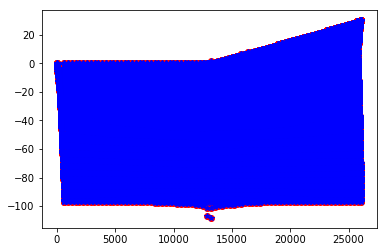

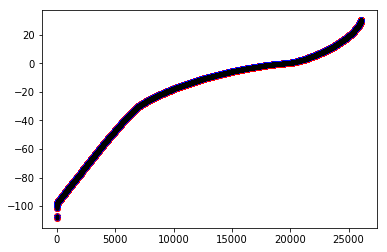

In [8]:
print "cant = " + str(min(u_cant[0]))
print "pyFEA = " + str(min(u))
print "pyFEA_lag = " + str(min(sol_lsto[:nDOF]))
print "fem2d = " + str(min(sol[:nDOF]))
print "fem2d_LSTO = " + str(min(sol2[:nDOF]))
# OK.
print np.std(u)
print np.std(sol_lsto[:nDOF])
print np.std(sol[:nDOF])
print np.std(sol2[:nDOF])
# OK.
plt.plot(u,'ro')
plt.plot(sol_lsto[:nDOF],'b*')
plt.show()

plt.plot(np.sort(u),'ro')
plt.plot(np.sort(sol_lsto[:nDOF]),'b*')
plt.plot(np.sort(sol2[:nDOF]),'k.')
plt.show() 

# OK. 

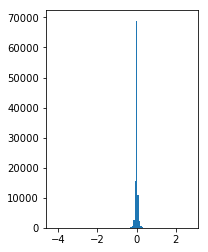

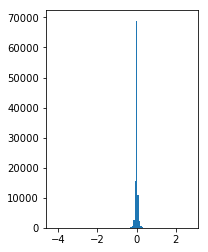

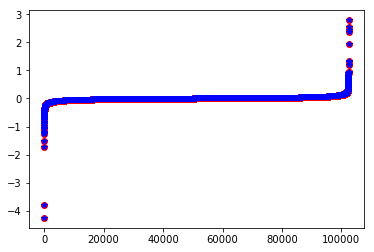

0.0668894046464
0.0668894046466


In [9]:
# sensitivity calculation (SIMP) (cant(correct) vs. pyFEA vs. FEM2D)
## CANT VER

## OPENLSTO VER
# u_openlsto = sol_lsto[:nDOF]
# (rows, cols, vals) = pyFEA.compute_K_SIMP_derivs(np.array(u)) # OK
(rows, cols, vals) = pyFEA.compute_K_SIMP_derivs(sol_lsto) # OK

nprows = np.array(rows)
npcols = np.array(cols)
npvals = np.array(vals)

mtx = scipy.sparse.csc_matrix((npvals, (nprows, npcols)), shape = (nDOF_withLag, num_elem))

## FEM2D VER
data1 = data2 = np.zeros(size)
rows1 = rows2 = np.zeros(size, np.int32)
cols1 = cols2 = np.zeros(size, np.int32)
fem_solver.get_stiffness_matrix_SIMP_derivs(sol2, data1, rows1, cols1)
mtx = scipy.sparse.csc_matrix((data1, (rows1, cols1)), shape=(state_size, num_elem))


## PLOTS (HIST)
plt.figure(1)
plt.subplot(1,2,1)
plt.hist(npvals,100)
plt.show()

plt.subplot(1,2,2)
plt.hist(data1[:npvals.shape[0]],100)
plt.show()

plt.figure(2)
plt.plot(np.sort(npvals),'ro')

plt.plot(np.sort(data1[:npvals.shape[0]]),'b*')
plt.show()

np.savetxt('npval',np.sort(npvals))
np.savetxt('data1',np.sort(data1[:npvals.shape[0]]))

## MEASURES
print np.std(npvals)
print np.std(data1[:npvals.shape[0]])
# OK.

In [10]:
# parameterized FEA (pyFEA vs. FEM2D(correct))
parameters = np.random.rand(num_node)

parameters_yx = parameters.reshape((num_nodes_x, num_nodes_y),order='F')
parameters_yx = parameters_yx.flatten()

## OPENLSTO VER
(rows, cols, vals) = pyFEA.compute_K_PARM(parameters)

nprows = np.array(rows)
npcols = np.array(cols)
npvals = np.array(vals)

mtx = scipy.sparse.csc_matrix((npvals, (nprows, npcols)), shape = (nDOF_withLag, nDOF_withLag))

GF = np.zeros(nDOF_withLag)
GF[:nDOF] = GF_ #rhs.transpose().flatten(order = 'F')

sol_lsto = scipy.sparse.linalg.spsolve(mtx, GF) # direct solver is used

## FEM2D VER
data1 = np.zeros(size)
rows1 = np.zeros(size, np.int32)
cols1 = np.zeros(size, np.int32)

fem_solver.get_stiffness_matrix(parameters_yx, data1, rows1, cols1)
mtx = scipy.sparse.csc_matrix((data1, (rows1, cols1)), shape=(state_size, state_size))

sol = scipy.sparse.linalg.spsolve(mtx, rhs)

In [11]:
print "pyFEA_lag = " + str(min(sol_lsto[:nDOF]))
print "fem2d = " + str(min(sol[:nDOF]))
# OK.

pyFEA_lag = -88.2837189849
fem2d = -88.2837189836


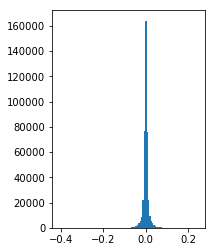

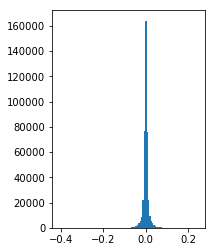

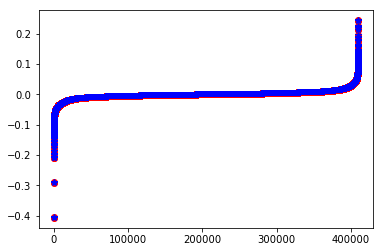

0.0134076552334
0.0134076552332


In [12]:
# sensitivity calculation (Param) (pyFEA vs. FEM2D(Correct))

## OPENLSTO VER.
(rows, cols, vals) = pyFEA.compute_K_PARM_derivs(sol_lsto)

nprows = np.array(rows)
npcols = np.array(cols)
npvals = np.array(vals)

## FEM2D VER
data1 = np.zeros(size)
rows1 = np.zeros(size, np.int32)
cols1 = np.zeros(size, np.int32)

fem_solver.get_stiffness_matrix_derivs(sol, data1, rows1, cols1)

## PLOTS (HIST)
plt.figure(1)
plt.subplot(1,2,1)
plt.hist(npvals,100)
plt.show()

plt.subplot(1,2,2)
plt.hist(data1[:npvals.shape[0]],100)
plt.show()

plt.figure(2)
plt.plot(np.sort(npvals),'ro')

plt.plot(np.sort(data1[:npvals.shape[0]]),'b*')
plt.show()

print np.std(npvals)
print np.std(data1[:npvals.shape[0]])
# OK.

In [13]:
# Gauss point sensitivity calculation (for LSTO)
# Cant(correct) vs. pyFEA vs. FEM2D
# NOTE: in OPENLSTO, area_min was hard coded to be 0.1 (CANT = 0.001, so OPENLSTO to 0.001)
# NOTE: if uniform areafraction, three solutions are same 
areafrac_new = np.random.rand(num_elem) #np.ones(num_elem)*0.5 
# CANT
u_cant = cant.get_u(areafrac_new, f = -1.0)
Gpts_xy = cant.get_IntegPoints_xy()
(IntegrationPointSensitivities, bpts_sens) = cant.get_sens()

# pyFEA
pyFEA.compute_K_SIMP(areafrac_new) #areafraction)
u = pyFEA.solve_FE()
pySens = py_Sensitivity(pyFEA, u)
py_GptsSens = pySens.compute_compliance_sens()

# FEM2D
xpos = np.zeros(size)
ypos = np.zeros(size)
sens = np.zeros(size)

areafraction_new_yx = areafrac_new.reshape((num_elems_x, num_elems_y),order='F')
areafraction_new_yx = areafraction_new_yx.flatten()

fem_solver.set_area_fractions(areafraction_new_yx)

data1 = np.zeros(size)
rows1 = np.zeros(size, np.int32)
cols1 = np.zeros(size, np.int32)

fem_solver.get_stiffness_matrix_SIMP(data1, rows1, cols1)
mtx = scipy.sparse.csc_matrix((data1, (rows1, cols1)), shape=(state_size, state_size))

sol = scipy.sparse.linalg.spsolve(mtx, rhs)

fem_solver.get_sensitivity_LSTO(sol, xpos, ypos, sens)

In [14]:
print (np.max(u_cant), np.min(u_cant),  np.std(u_cant))
print (np.max(u), np.min(u),  np.std(u))
print (np.max(sol), np.min(sol),  np.std(sol))

(30.542248511171799, -106.15079422239542, 30.023358214431671)
(30.538079639392933, -106.1507560407472, 30.022803837520183)
(30.542248510702851, -106.15079422096363, 29.96828494579669)


In [15]:
print (np.max(IntegrationPointSensitivities.flatten()), np.min(IntegrationPointSensitivities.flatten()),  np.std(IntegrationPointSensitivities.flatten()))
print (np.max(-py_GptsSens[:,2]), np.min(-py_GptsSens[:,2]),  np.std(-py_GptsSens[:,2]))
print (np.max(sens[:Gpts_xy.shape[0]]), np.min(sens[:Gpts_xy.shape[0]]), np.std(sens[:Gpts_xy.shape[0]]))


(4.3568652814063373, 0.0, 0.03275455904801873)
(4.3568645412200633, -0.0, 0.032754497249247734)
(4.3568652814056072, 0.0, 0.03275364653715767)


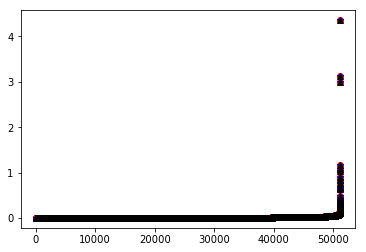

In [16]:
plt.figure()
plt.plot(np.sort(IntegrationPointSensitivities.flatten()),'ro')
plt.plot(np.sort(-py_GptsSens[:,2]),'b*')
plt.plot(np.sort(sens[:Gpts_xy.shape[0]]),'k^')
plt.show()

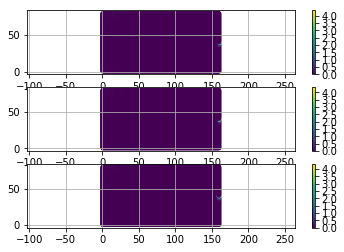

In [17]:
plt.figure()
plt.clf()
plt.subplot(3,1,1)
plt.scatter(Gpts_xy[:,0],Gpts_xy[:,1],10,IntegrationPointSensitivities.flatten())
plt.axis('equal')
plt.colorbar()
plt.grid()
# plt.show()

plt.subplot(3,1,2)
plt.scatter(py_GptsSens[:,0],py_GptsSens[:,1],10,-py_GptsSens[:,2])
plt.axis('equal')
plt.colorbar()
plt.grid()



plt.subplot(3,1,3)
plt.scatter(xpos[:Gpts_xy.shape[0]], ypos[:Gpts_xy.shape[0]], 10, sens[:Gpts_xy.shape[0]])
plt.axis('equal')
plt.colorbar()
plt.grid()


plt.show()

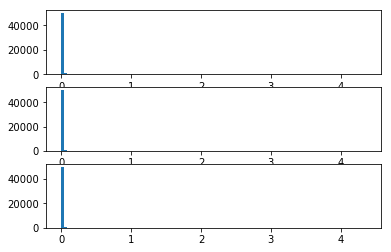

In [18]:
plt.figure(2)
plt.clf()
plt.subplot(3,1,1)
plt.hist(IntegrationPointSensitivities.flatten(),100)

plt.subplot(3,1,2)
plt.hist(-py_GptsSens[:,2],100)

plt.subplot(3,1,3)
plt.hist(sens[:Gpts_xy.shape[0]],100)

plt.show()

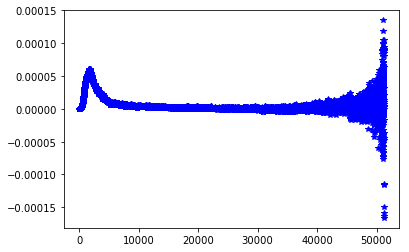

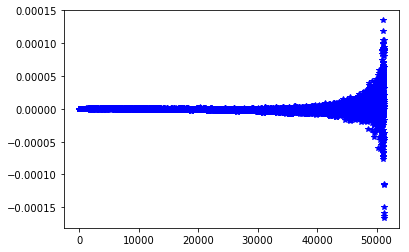

In [19]:
plt.figure()
plt.plot(np.sort(-py_GptsSens[:,2])-np.sort(IntegrationPointSensitivities.flatten()),'b*')
plt.show()

plt.figure()
plt.plot(np.sort(-py_GptsSens[:,2])-np.sort(sens[:Gpts_xy.shape[0]]),'b*')
plt.show()